# PUF Counties Aggregate - Classification 

DeSYNPuf Counties Aggregate with Elixhauser Sums per User & RWJF Factor Rankings Dataset

In [1]:
%matplotlib inline
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing as pre

The file contains aggregated Medicare data from 2008-2010 (DeSYNPuf Synthetic Public Use Files), and RWJF County Health Factors and Outcomes Ranking Data from 2010.

2694 out of 3012 counties will be analyzed.

The following rules were applied to transform variables and eliminate outliers before performing this analysis:

1. TOT_VSTS_PB cut >= 20
2. CODES_PU cut >= 25
3. PROCS_PU cut >= 30
4. IPDAYS_PU transformed to square root(IPDAYS_PU), cut >= 4.5 and 0 values transformed to 0.1
5. TOT_CC_INCD cut >= 4.5
6. COST_PB transformed to square root(COST_PB), cut > 520
7. CNTY_IP_PROP cut >= 0.25 and IP_PROP = 1 excluded (2 rows)
8. CNTY_USR_PROP cut <= 0.2

Total counties removed = 179 rows

In [2]:
medicare_counties = pd.read_csv("/home/kylier/python/DS/data/PUF/PUF_RWJF_MERGED_CLUST_OUTLIERS_REM.csv")
medicare_counties.shape


(2694, 79)

In [3]:
medicare_counties.drop(columns=medicare_counties.columns[0], axis=1, inplace=True, errors="ignore")

## Classification

In this notebook, I will show how one can use the Random Forest Classifier to try to predict high cost counties.

A high cost county will be defined as counties where SR[TOT_COST_PB] > 215 (which is the mean). 

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

In [5]:
# Again, we will begin with Age, Sex and Race indicators in the model.
# The classification model will rate the importance of the variables after it uses them to make decisions.

medicare_counties.loc[medicare_counties["SR[TOT_COST_PB]"]>215, "HIGH_COST"] = 1
medicare_counties.loc[medicare_counties["SR[TOT_COST_PB]"]<=215, "HIGH_COST"] = 0

df = medicare_counties[["CNTY_MEAN_AGE", "CNTY_SEX_PROP", "DIVERSE_PROP", "CNTY_IP_PROP", "TOT_VSTS_PB", 
                       "CODES_PU", "PROCS_PU", "PRVDRS_PU", "SR[TOT_IPDAYS_PU]", "TOT_CC_PREV", "TOT_CC_INCD",
                       "TOT_ELIX_PU", "TOT_ESRD_PREV"]]


In [6]:
medicare_counties["HIGH_COST"].value_counts()

1.0    1388
0.0    1306
Name: HIGH_COST, dtype: int64

In [7]:
s = pre.StandardScaler()
df = s.fit_transform(df)

df = pd.DataFrame(df, columns=["CNTY_MEAN_AGE", "CNTY_SEX_PROP", "DIVERSE_PROP", "CNTY_IP_PROP", "TOT_VSTS_PB", 
                       "CODES_PU", "PROCS_PU", "PRVDRS_PU", "SR[TOT_IPDAYS_PU]", "TOT_CC_PREV", "TOT_CC_INCD",
                       "TOT_ELIX_PU", "TOT_ESRD_PREV"])
df["HIGH_COST"] = medicare_counties["HIGH_COST"]

train, test = train_test_split(df, test_size=0.25, random_state=121)

train

,CNTY_MEAN_AGE,CNTY_SEX_PROP,DIVERSE_PROP,CNTY_IP_PROP,TOT_VSTS_PB,CODES_PU,PROCS_PU,PRVDRS_PU,SR[TOT_IPDAYS_PU],TOT_CC_PREV,TOT_CC_INCD,TOT_ELIX_PU,TOT_ESRD_PREV,HIGH_COST
2609,-4.624795,-1.455192,-1.041787,3.358003,0.195268,2.361403,0.554634,-0.040684,2.860311,0.681311,0.972505,-0.240615,-1.350328,1.0
1845,0.685721,-0.173124,0.785486,-0.417294,0.330112,0.123772,0.228734,0.716158,-0.451168,-0.211862,-0.608357,0.191126,-0.550733,0.0
364,-0.445035,0.049629,0.459540,0.365825,-0.793029,-0.813047,-0.844122,-0.198075,0.000718,-0.216891,-0.303171,-0.737252,-0.118520,0.0
768,-0.081578,0.647246,-1.041787,-0.657501,0.156450,-0.143372,0.115922,-0.978002,-0.332723,-0.357235,-0.215158,-0.465811,-0.400809,0.0
2236,0.544377,-0.769757,0.536312,1.218596,0.632859,0.954612,0.509638,0.692870,1.186717,0.978612,0.289860,-0.048872,0.721349,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,2.482816,-2.615157,-1.041787,-1.908231,-1.978566,-2.854018,-1.767161,-1.833815,-2.231963,-0.909653,0.359518,-2.750628,6.245822,0.0
1716,-0.263306,-0.308407,0.615217,-0.333635,0.328486,0.520565,0.367675,0.876259,0.165965,-0.126224,-0.389302,-0.021295,-0.400809,1.0
2113,0.160727,0.699030,-1.041787,0.771906,-1.202197,-1.392328,-1.912948,-1.833815,-0.610738,-0.152051,0.578442,0.530851,-1.350328,0.0
1631,0.483800,-0.783633,0.785486,0.104439,-0.977458,-1.134988,-0.876240,-0.741635,-0.745700,-0.258381,-0.850326,-0.468624,-0.950530,0.0


In [8]:
train_x = train[["CNTY_MEAN_AGE", "CNTY_SEX_PROP", "DIVERSE_PROP", "CNTY_IP_PROP", "TOT_VSTS_PB", 
                 "CODES_PU", "PROCS_PU", "PRVDRS_PU", "SR[TOT_IPDAYS_PU]", "TOT_CC_PREV", "TOT_CC_INCD",
                 "TOT_ELIX_PU", "TOT_ESRD_PREV"]]
train_y = train["HIGH_COST"]

test_x = test[["CNTY_MEAN_AGE", "CNTY_SEX_PROP", "DIVERSE_PROP", "CNTY_IP_PROP", "TOT_VSTS_PB", 
               "CODES_PU", "PROCS_PU", "PRVDRS_PU", "SR[TOT_IPDAYS_PU]", "TOT_CC_PREV", "TOT_CC_INCD",
               "TOT_ELIX_PU", "TOT_ESRD_PREV"]]
test_y = test["HIGH_COST"]

In [9]:
#The default criterion is "gini". We can also run with criterion "entropy" for information gain,
#rather than impurity
clf = RandomForestClassifier(min_samples_leaf=10, random_state=121)
clf.fit(train_x, train_y)

# predict on test data
prediction = clf.predict(test_x)

# compute evaluation scores
accuracy = accuracy_score(test_y, prediction)
precision = precision_score(test_y, prediction)
recall = recall_score(test_y, prediction)
cm = confusion_matrix(test_y, prediction)
roc = roc_auc_score(test_y, prediction)
f1 = f1_score(test_y, prediction)

In [10]:
accuracy

0.8456973293768546

In [11]:
precision

0.8672086720867209

In [12]:
recall

0.8533333333333334

In [13]:
f1

0.860215053763441

## Scores

These are great scores for a simple Random Forest Classifier without any boosting.

The meaning of all these scores is worth reading up on.  

Now let's look at the Feature Importances of each of the variables in the model.

<AxesSubplot:>

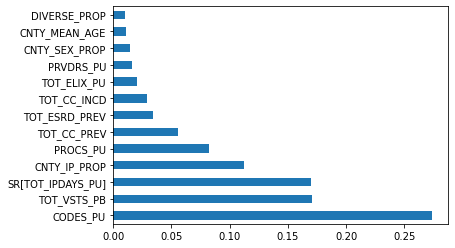

In [18]:
feat_importances = pd.Series(clf.feature_importances_, index=train_x.columns)
feat_importances.nlargest(13).plot(kind='barh')

## Feature Importances

CODES_PU was the most useful variable to the decision tree, in classifying counties into high cost or low cost!

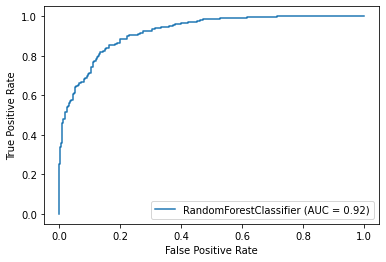

In [20]:
from sklearn.metrics import plot_roc_curve

clf_disp = plot_roc_curve(clf, test_x, test_y)
plt.show()

## AUC

AUC for the holdout (test) data is 0.92!

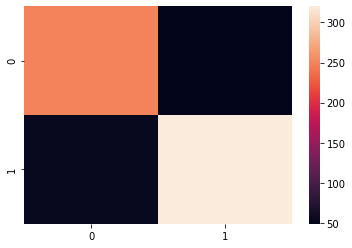

In [22]:
sb.heatmap(cm)
plt.show()

In [23]:
cm

array([[250,  49],
       [ 55, 320]])

## Confusion Matrix

The confusion matrix shows the actual positives and negatives of the target classification (in this case, HIGH_COST) on the left column, plotted against the predicted positives and negatives going across the rows.

Above, the first cell contains TRUE POSITIVES (times the true value was positive, and the classifier predicted positive).  The classifier correctly predicted 250 out of 299 positive cases.

The second cell contains the FALSE NEGATIVES (times the true value was positive, and the classifier predicted negative).  The classifier incorrectly classified 49 positive cases as negative.

The second row, first cell contains the FALSE NEGATIVES (times the true value was negative, and the classifier predicted positive).  The classifier incorrectly classified 55 negative cases as positive.

The second row, second cell contains the TRUE NEGATIVES (times the true value was negative, and the classifier predicted negative).  The classifier correctly predicted 320 out of 375 nevative cases.

The confusion matrix values can be used to calculate a wide variety of other important model metrics:

https://en.wikipedia.org/wiki/Confusion_matrix

## Now...

Let's try the whole model using "entropy" criterion instead of "gini" - just for comparison!

In [24]:
clf2 = RandomForestClassifier(criterion="entropy", min_samples_leaf=10, random_state=121)
clf2.fit(train_x, train_y)

# predict on test data
prediction2 = clf2.predict(test_x)

# compute evaluation scores
accuracy2 = accuracy_score(test_y, prediction2)
precision2 = precision_score(test_y, prediction2)
recall2 = recall_score(test_y, prediction2)
cm2 = confusion_matrix(test_y, prediction2)
roc2 = roc_auc_score(test_y, prediction2)
f12 = f1_score(test_y, prediction2)

In [25]:
accuracy2

0.8397626112759644

In [26]:
precision2

0.8541114058355438

In [27]:
recall2

0.8586666666666667

In [28]:
f12

0.8563829787234042

<AxesSubplot:>

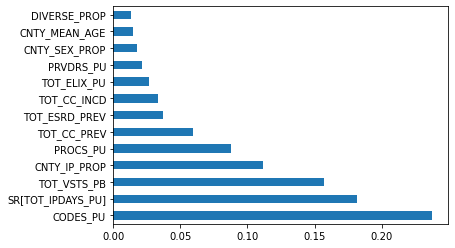

In [29]:
feat_importances2 = pd.Series(clf2.feature_importances_, index=train_x.columns)
feat_importances2.nlargest(13).plot(kind='barh')

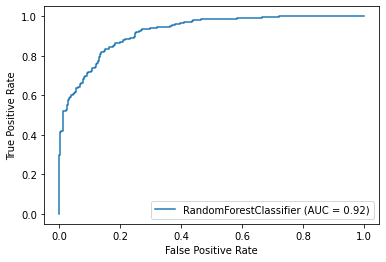

In [30]:
clf_disp2 = plot_roc_curve(clf2, test_x, test_y)
plt.show()

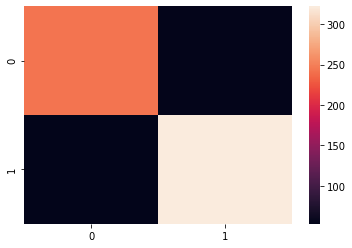

In [31]:
sb.heatmap(cm2)
plt.show()

In [32]:
cm2

array([[244,  55],
       [ 53, 322]])

So, it looks as though the "gini" model did slightly better than "entropy" at distinguishing true positives from true negatives.  The "entropy" model made a few more mistakes.  

The AUC and recall scores were similar, but accuracy and precision were better for the "gini" model.

## Lastly...

What if we tried to classify the holdout set using only the new FACTOR variables?

(No need to scale them, they were scaled when they were created.)

In [39]:
mc = pd.read_csv("/home/kylier/python/DS/data/PUF/PUF_RWJF_MERGED_CLUSTERED_NOOUTLIERS.csv")
mc.shape

(2694, 82)

In [41]:
mc.drop(columns=medicare_counties.columns[0], axis=1, inplace=True, errors="ignore")

In [44]:
mc.loc[mc["SR[TOT_COST_PB]"]>215, "HIGH_COST"] = 1
mc.loc[mc["SR[TOT_COST_PB]"]<=215, "HIGH_COST"] = 0

df = mc[["FACTORS_1", "FACTORS_2", "FACTORS_3", "HIGH_COST"]]
train, test = train_test_split(df, test_size=0.25, random_state=121)

train

,FACTORS_1,FACTORS_2,FACTORS_3,HIGH_COST
2609,1.203530,-0.082198,3.215759,1.0
1845,0.363923,-0.212502,-0.490816,0.0
364,-0.920505,-0.154060,0.345301,0.0
768,0.125176,-0.248373,-0.583093,0.0
2236,0.445535,0.708567,1.137493,1.0
...,...,...,...,...
339,-2.383877,-0.188244,-1.836699,0.0
1716,0.710364,-0.216946,-0.206125,1.0
2113,-1.832725,0.035816,0.509445,0.0
1631,-1.182440,-0.100580,-0.047120,0.0


In [45]:
train_x = train[["FACTORS_1", "FACTORS_2", "FACTORS_3"]]
train_y = train["HIGH_COST"]

test_x = test[["FACTORS_1", "FACTORS_2", "FACTORS_3"]]
test_y = test["HIGH_COST"]

In [46]:
clf3 = RandomForestClassifier(min_samples_leaf=10, random_state=121)
clf3.fit(train_x, train_y)

# predict on test data
prediction3 = clf3.predict(test_x)

# compute evaluation scores
accuracy3 = accuracy_score(test_y, prediction3)
precision3 = precision_score(test_y, prediction3)
recall3 = recall_score(test_y, prediction3)
cm3 = confusion_matrix(test_y, prediction3)
roc3 = roc_auc_score(test_y, prediction3)
f13 = f1_score(test_y, prediction3)

In [47]:
accuracy3

0.8249258160237388

In [48]:
precision3

0.8426666666666667

In [49]:
recall3

0.8426666666666667

In [50]:
f13

0.8426666666666667

<AxesSubplot:>

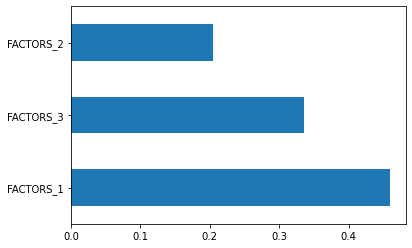

In [51]:
feat_importances3 = pd.Series(clf3.feature_importances_, index=train_x.columns)
feat_importances3.nlargest(3).plot(kind='barh')

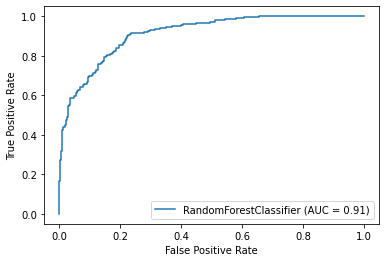

In [52]:
clf_disp3 = plot_roc_curve(clf3, test_x, test_y)
plt.show()

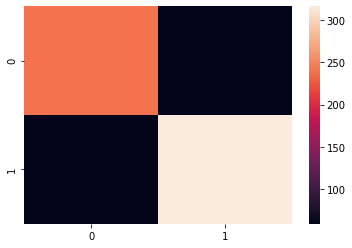

In [53]:
sb.heatmap(cm3)
plt.show()

In [54]:
cm3

array([[240,  59],
       [ 59, 316]])

## Results with Dimension Reduction

The Factor Analysis was a form of dimension reduction - we "boiled" a bunch of variables down to 3 variables that had almost the same power to allow an accurate prediction of the classification as the original model!